# Preparing the data

In this notebook we will prepare the datasets for implementation.

In [3]:
import pandas as pd
import urllib.parse
import urllib.error
import pickle
import time
import sys
import glob
import pickle

import numpy as np
from IPython.display import clear_output

# set relative path
countries_capitals_path = '../../data/auxilary_data/countries_codes_full.csv'
data_folder_path = '../../data/GDELT/'
themes_path = '../../data/auxilary_data/themes_final_set.pickle'

In [2]:
# save data_pivot to csv
df = pd.read_csv(f"{data_folder_path}/saved_data/afghanistan_full.csv")
df_counts = pd.read_csv(f"{data_folder_path}/saved_data/afghanistan_full_counts.csv")
countries_codes = pd.read_csv(f"{countries_capitals_path}")

In [3]:
# make dictionary from FIPS to GDELT_name from countries codes df
fips_to_name = dict(zip(countries_codes['FIPS'], countries_codes['GDELT_name']))

# convert fips to name
df_counts["Source country"] = df_counts["FIPS"].map(fips_to_name)

df_counts.head()

,FIPS,Month,Article Count,Total Monitored Articles,Source country
0,AA,2017-01-31,0.0,22396121.0,Aruba
1,AA,2017-02-28,0.0,21353650.0,Aruba
2,AA,2017-03-31,0.0,22943283.0,Aruba
3,AA,2017-04-30,0.0,20062498.0,Aruba
4,AA,2017-05-31,0.0,19926573.0,Aruba


In [4]:
# join df and df_counts
df_joined = df_counts[["Month", "Source country", "Article Count",]].merge(df, on=["Source country", "Month"])

In [5]:
df_joined.head()

,Month,Source country,Article Count,ACT_MAKESTATEMENT,AFFECT,AGRICULTURE,ALL,ALLIANCE,APPOINTMENT,ARMEDCONFLICT,...,WB_862_GROWTH_POLES_AND_ECONOMIC_ZONES,WB_866_CONNECTIVITY_AND_LAGGING_REGIONS,WB_895_MINING_SYSTEMS,WB_936_ALTERNATIVE_DISPUTE_RESOLUTION,WB_938_MEDIATION,WB_939_NEGOTIATION,WB_962_INTERNATIONAL_LAW,WB_990_DRAINAGE,WMD,WOUND
0,2017-01-31,United Arab Emirates,1341.0,0.045297,0.422033,0.067673,3.956983,0.111147,0.030733,2.147490,...,0.008407,0.003823,0.231410,0.071433,0.000000,0.071433,0.022917,0.000000,0.023083,0.690960
1,2017-02-28,United Arab Emirates,726.0,0.028239,0.262921,0.047432,1.873036,0.167118,0.015879,0.746546,...,0.002014,0.003761,0.018821,0.045157,0.000000,0.043064,0.017996,0.000000,0.024868,0.305661
2,2017-03-31,United Arab Emirates,319.0,0.004906,0.134577,0.022884,0.715829,0.057690,0.028271,0.400813,...,0.005413,0.003810,0.026303,0.038197,0.000000,0.030519,0.005719,0.003471,0.006935,0.113610
3,2017-04-30,United Arab Emirates,498.0,0.023030,0.163007,0.018503,1.152687,0.068180,0.016830,0.550830,...,0.000000,0.000000,0.026957,0.244260,0.200990,0.041317,0.006940,0.001797,0.056877,0.184663
4,2017-05-31,United Arab Emirates,530.0,0.028713,0.171168,0.018710,1.199919,0.136910,0.004371,0.812916,...,0.007052,0.004239,0.024303,0.030884,0.003216,0.027668,0.013190,0.004300,0.010668,0.210871


In [7]:
len(df_joined["Source country"].unique())

162

First we normalize the theme data by dividing each column by "ALL" and multiplying it by 100. This way we get the percentage of each theme in the total number of themes.

In [96]:
df_normalized = df_joined.copy()

columns = df_normalized.columns.tolist()

for column in df_normalized.columns:
    if column not in ["Month", "Source country", "Article Count", "ALL"]:
        df_normalized[column] = df_normalized[column] / df_normalized["ALL"] * 100

In [97]:
df_normalized.head()

,Month,Source country,Article Count,ACT_MAKESTATEMENT,AFFECT,AGRICULTURE,ALL,ALLIANCE,APPOINTMENT,ARMEDCONFLICT,...,WB_862_GROWTH_POLES_AND_ECONOMIC_ZONES,WB_866_CONNECTIVITY_AND_LAGGING_REGIONS,WB_895_MINING_SYSTEMS,WB_936_ALTERNATIVE_DISPUTE_RESOLUTION,WB_938_MEDIATION,WB_939_NEGOTIATION,WB_962_INTERNATIONAL_LAW,WB_990_DRAINAGE,WMD,WOUND
0,2017-01-31,United Arab Emirates,1341.0,1.144727,10.665532,1.710225,3.956983,2.808874,0.776686,54.270888,...,0.212451,0.096622,5.848142,1.805247,0.000000,1.805247,0.579145,0.000000,0.583357,17.461787
1,2017-02-28,United Arab Emirates,726.0,1.507675,14.037182,2.532367,1.873036,8.922300,0.847745,39.857565,...,0.107541,0.200782,1.004862,2.410907,0.000000,2.299171,0.960816,0.000000,1.327677,16.319001
2,2017-03-31,United Arab Emirates,319.0,0.685422,18.800218,3.196835,0.715829,8.059232,3.949402,55.992826,...,0.756173,0.532205,3.674512,5.336019,0.000000,4.263498,0.798983,0.484888,0.968874,15.871063
3,2017-04-30,United Arab Emirates,498.0,1.997941,14.141455,1.605235,1.152687,5.914877,1.460067,47.786620,...,0.000000,0.000000,2.338594,21.190494,17.436655,3.584380,0.602072,0.155868,4.934270,16.020254
4,2017-05-31,United Arab Emirates,530.0,2.392903,14.264937,1.559245,1.199919,11.409907,0.364272,67.747564,...,0.587674,0.353250,2.025405,2.573829,0.268029,2.305800,1.099267,0.358357,0.889038,17.573762


We first define the countries that are in the regional sphere of afghanistan:

In [7]:
regional = [
    "Iran",
    "Turkmenistan",
    "Pakistan",
    "Uzbekistan",
    "Tajikistan",
    "Azerbaijan",
    "Kyrgyzstan",
    "China",
    "India",
    "Kazakhstan"
]

And classify what each country is in the dataframe

In [98]:
#set df_normalized["News_kind"] to "Regional" if df_normalized["Source country"] is in regional else "Local"
df_normalized["News_kind"] = df_normalized["Source country"].apply(lambda x: "Regional" if x in regional else "Local" if x == "Afghanistan" else "International")

columns = ["Month", "Source country", "News_kind", "Article Count", "ALL"] + df_normalized.columns.to_list()[3:-1]
df_normal = df_normalized[columns]
df_normal.columns = ["Month", "Source country", "News_kind", "Article Count", "All_coverage"] + df_normalized.columns.to_list()[3:-1]
df_normal.head()

/tmp/ipykernel_5995/1889638063.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized["News_kind"] = df_normalized["Source country"].apply(lambda x: "Regional" if x in regional else "Local" if x == "Afghanistan" else "International")


,Month,Source country,News_kind,Article Count,All_coverage,ACT_MAKESTATEMENT,AFFECT,AGRICULTURE,ALL,ALLIANCE,...,WB_862_GROWTH_POLES_AND_ECONOMIC_ZONES,WB_866_CONNECTIVITY_AND_LAGGING_REGIONS,WB_895_MINING_SYSTEMS,WB_936_ALTERNATIVE_DISPUTE_RESOLUTION,WB_938_MEDIATION,WB_939_NEGOTIATION,WB_962_INTERNATIONAL_LAW,WB_990_DRAINAGE,WMD,WOUND
0,2017-01-31,United Arab Emirates,International,1341.0,3.956983,1.144727,10.665532,1.710225,3.956983,2.808874,...,0.212451,0.096622,5.848142,1.805247,0.000000,1.805247,0.579145,0.000000,0.583357,17.461787
1,2017-02-28,United Arab Emirates,International,726.0,1.873036,1.507675,14.037182,2.532367,1.873036,8.922300,...,0.107541,0.200782,1.004862,2.410907,0.000000,2.299171,0.960816,0.000000,1.327677,16.319001
2,2017-03-31,United Arab Emirates,International,319.0,0.715829,0.685422,18.800218,3.196835,0.715829,8.059232,...,0.756173,0.532205,3.674512,5.336019,0.000000,4.263498,0.798983,0.484888,0.968874,15.871063
3,2017-04-30,United Arab Emirates,International,498.0,1.152687,1.997941,14.141455,1.605235,1.152687,5.914877,...,0.000000,0.000000,2.338594,21.190494,17.436655,3.584380,0.602072,0.155868,4.934270,16.020254
4,2017-05-31,United Arab Emirates,International,530.0,1.199919,2.392903,14.264937,1.559245,1.199919,11.409907,...,0.587674,0.353250,2.025405,2.573829,0.268029,2.305800,1.099267,0.358357,0.889038,17.573762


Then we compute the total number of articles per category per month

In [99]:
df_normal["Total_in_kind"] = df_normal.groupby(["Month", "News_kind"])["Article Count"].transform("sum")
df_normal.head()

/tmp/ipykernel_5995/2227178298.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normal["Total_in_kind"] = df_normal.groupby(["Month", "News_kind"])["Article Count"].transform("sum")
/tmp/ipykernel_5995/2227178298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal["Total_in_kind"] = df_normal.groupby(["Month", "News_kind"])["Article Count"].transform("sum")


,Month,Source country,News_kind,Article Count,All_coverage,ACT_MAKESTATEMENT,AFFECT,AGRICULTURE,ALL,ALLIANCE,...,WB_866_CONNECTIVITY_AND_LAGGING_REGIONS,WB_895_MINING_SYSTEMS,WB_936_ALTERNATIVE_DISPUTE_RESOLUTION,WB_938_MEDIATION,WB_939_NEGOTIATION,WB_962_INTERNATIONAL_LAW,WB_990_DRAINAGE,WMD,WOUND,Total_in_kind
0,2017-01-31,United Arab Emirates,International,1341.0,3.956983,1.144727,10.665532,1.710225,3.956983,2.808874,...,0.096622,5.848142,1.805247,0.000000,1.805247,0.579145,0.000000,0.583357,17.461787,107720.0
1,2017-02-28,United Arab Emirates,International,726.0,1.873036,1.507675,14.037182,2.532367,1.873036,8.922300,...,0.200782,1.004862,2.410907,0.000000,2.299171,0.960816,0.000000,1.327677,16.319001,103242.0
2,2017-03-31,United Arab Emirates,International,319.0,0.715829,0.685422,18.800218,3.196835,0.715829,8.059232,...,0.532205,3.674512,5.336019,0.000000,4.263498,0.798983,0.484888,0.968874,15.871063,90662.0
3,2017-04-30,United Arab Emirates,International,498.0,1.152687,1.997941,14.141455,1.605235,1.152687,5.914877,...,0.000000,2.338594,21.190494,17.436655,3.584380,0.602072,0.155868,4.934270,16.020254,125536.0
4,2017-05-31,United Arab Emirates,International,530.0,1.199919,2.392903,14.264937,1.559245,1.199919,11.409907,...,0.353250,2.025405,2.573829,0.268029,2.305800,1.099267,0.358357,0.889038,17.573762,102317.0


In [100]:
df_normal["Weight"] = df_normal["Article Count"] / df_normal["Total_in_kind"] * 100
df_normal.head()

/tmp/ipykernel_5995/1584134230.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normal["Weight"] = df_normal["Article Count"] / df_normal["Total_in_kind"] * 100
/tmp/ipykernel_5995/1584134230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal["Weight"] = df_normal["Article Count"] / df_normal["Total_in_kind"] * 100


,Month,Source country,News_kind,Article Count,All_coverage,ACT_MAKESTATEMENT,AFFECT,AGRICULTURE,ALL,ALLIANCE,...,WB_895_MINING_SYSTEMS,WB_936_ALTERNATIVE_DISPUTE_RESOLUTION,WB_938_MEDIATION,WB_939_NEGOTIATION,WB_962_INTERNATIONAL_LAW,WB_990_DRAINAGE,WMD,WOUND,Total_in_kind,Weight
0,2017-01-31,United Arab Emirates,International,1341.0,3.956983,1.144727,10.665532,1.710225,3.956983,2.808874,...,5.848142,1.805247,0.000000,1.805247,0.579145,0.000000,0.583357,17.461787,107720.0,1.244894
1,2017-02-28,United Arab Emirates,International,726.0,1.873036,1.507675,14.037182,2.532367,1.873036,8.922300,...,1.004862,2.410907,0.000000,2.299171,0.960816,0.000000,1.327677,16.319001,103242.0,0.703202
2,2017-03-31,United Arab Emirates,International,319.0,0.715829,0.685422,18.800218,3.196835,0.715829,8.059232,...,3.674512,5.336019,0.000000,4.263498,0.798983,0.484888,0.968874,15.871063,90662.0,0.351856
3,2017-04-30,United Arab Emirates,International,498.0,1.152687,1.997941,14.141455,1.605235,1.152687,5.914877,...,2.338594,21.190494,17.436655,3.584380,0.602072,0.155868,4.934270,16.020254,125536.0,0.396699
4,2017-05-31,United Arab Emirates,International,530.0,1.199919,2.392903,14.264937,1.559245,1.199919,11.409907,...,2.025405,2.573829,0.268029,2.305800,1.099267,0.358357,0.889038,17.573762,102317.0,0.517998


In [101]:
df_weight = df_normal.copy()

for column in df_weight.columns:
    if column not in ["Month", "Source country", "Article Count", "All_coverage", "News_kind", "Total_in_kind", "Weight"]:
        df_weight[column] = df_weight[column] * df_weight["Weight"] / 100

In [102]:
df_weight.head()

,Month,Source country,News_kind,Article Count,All_coverage,ACT_MAKESTATEMENT,AFFECT,AGRICULTURE,ALL,ALLIANCE,...,WB_895_MINING_SYSTEMS,WB_936_ALTERNATIVE_DISPUTE_RESOLUTION,WB_938_MEDIATION,WB_939_NEGOTIATION,WB_962_INTERNATIONAL_LAW,WB_990_DRAINAGE,WMD,WOUND,Total_in_kind,Weight
0,2017-01-31,United Arab Emirates,International,1341.0,3.956983,0.014251,0.132775,0.021290,0.049260,0.034968,...,0.072803,0.022473,0.000000,0.022473,0.007210,0.000000,0.007262,0.217381,107720.0,1.244894
1,2017-02-28,United Arab Emirates,International,726.0,1.873036,0.010602,0.098710,0.017808,0.013171,0.062742,...,0.007066,0.016954,0.000000,0.016168,0.006756,0.000000,0.009336,0.114756,103242.0,0.703202
2,2017-03-31,United Arab Emirates,International,319.0,0.715829,0.002412,0.066150,0.011248,0.002519,0.028357,...,0.012929,0.018775,0.000000,0.015001,0.002811,0.001706,0.003409,0.055843,90662.0,0.351856
3,2017-04-30,United Arab Emirates,International,498.0,1.152687,0.007926,0.056099,0.006368,0.004573,0.023464,...,0.009277,0.084062,0.069171,0.014219,0.002388,0.000618,0.019574,0.063552,125536.0,0.396699
4,2017-05-31,United Arab Emirates,International,530.0,1.199919,0.012395,0.073892,0.008077,0.006216,0.059103,...,0.010492,0.013332,0.001388,0.011944,0.005694,0.001856,0.004605,0.091032,102317.0,0.517998


In [106]:
df_final = df_weight.groupby(["Month", "News_kind"]).sum().reset_index().drop(["Source country", "ALL", "Total_in_kind", "Weight"], axis=1)
df_final.head()

,Month,News_kind,Article Count,All_coverage,ACT_MAKESTATEMENT,AFFECT,AGRICULTURE,ALLIANCE,APPOINTMENT,ARMEDCONFLICT,...,WB_862_GROWTH_POLES_AND_ECONOMIC_ZONES,WB_866_CONNECTIVITY_AND_LAGGING_REGIONS,WB_895_MINING_SYSTEMS,WB_936_ALTERNATIVE_DISPUTE_RESOLUTION,WB_938_MEDIATION,WB_939_NEGOTIATION,WB_962_INTERNATIONAL_LAW,WB_990_DRAINAGE,WMD,WOUND
0,2017-01-31,International,107720.0,88.735850,4.342169,26.976634,3.892557,9.309922,3.986640,55.168878,...,0.119682,0.409997,3.281661,4.914507,0.489837,4.507409,3.732187,0.041097,3.884155,18.754480
1,2017-01-31,Local,5962.0,81.278090,5.632486,15.361922,4.879511,5.802154,3.293151,48.957556,...,0.169759,0.209384,1.397597,3.945762,0.212968,3.652563,2.672861,0.015244,1.617078,18.461765
2,2017-01-31,Regional,14212.0,29.396080,4.685235,19.201363,6.086256,9.255116,5.306860,51.098094,...,0.484795,1.430901,4.493146,5.641608,0.357173,5.017882,5.212595,0.088043,2.984574,15.102290
3,2017-02-28,International,103242.0,103.865968,4.563283,27.641664,5.201578,11.102661,4.826356,52.316501,...,0.188012,0.126065,3.984723,2.629101,0.304786,2.323985,3.323673,0.025704,2.978593,19.290400
4,2017-02-28,Local,5700.0,83.369568,2.982773,16.436637,5.091336,4.700328,3.835435,48.739843,...,0.168801,0.309298,1.335846,2.830148,0.226667,2.540076,3.107857,0.081933,0.496533,17.827797


## Then we merge the news data with the ACLED data

In [48]:
ACLED_data = pd.read_csv(f"../../data/ACLED/intensity_change_monthly_country.csv")

In [49]:
Afghanistan_data = ACLED_data[ACLED_data["country"] == "Afghanistan"]
Afghanistan_data.head()

,country,event_date,fatalities,hard_cases,log change,significant_change,sudden_escalation,sudden_deescalation
0,Afghanistan,2017-01-31,2415,False,NaN,False,False,False
1,Afghanistan,2017-02-28,2213,False,-0.087312,False,False,False
2,Afghanistan,2017-03-31,3217,False,0.373959,False,False,False
3,Afghanistan,2017-04-30,3681,False,0.134696,False,False,False
4,Afghanistan,2017-05-31,4351,False,0.167179,False,False,False


In [50]:
combined_data = df_final.merge(Afghanistan_data, left_on="Month", right_on="event_date", how="left")
combined_data.drop(["country", "event_date", "All_coverage"], axis=1, inplace=True)
combined_data.head()

NameError: name 'df_final' is not defined

In [120]:
# combined_data.to_csv(f"../../data/Test_training/afghanistan.csv", index=False)   

In [4]:
combined_data = pd.read_csv(f"../../data/Test_training/afghanistan.csv")
combined_data.head()

,Month,News_kind,Article Count,ACT_MAKESTATEMENT,AFFECT,AGRICULTURE,ALLIANCE,APPOINTMENT,ARMEDCONFLICT,ARREST,...,WB_962_INTERNATIONAL_LAW,WB_990_DRAINAGE,WMD,WOUND,fatalities,hard_cases,log change,significant_change,sudden_escalation,sudden_deescalation
0,2017-01-31,International,107720.0,4.342169,26.976634,3.892557,9.309922,3.986640,55.168878,18.802773,...,3.732187,0.041097,3.884155,18.754480,2415,False,NaN,False,False,False
1,2017-01-31,Local,5962.0,5.632486,15.361922,4.879511,5.802154,3.293151,48.957556,15.039978,...,2.672861,0.015244,1.617078,18.461765,2415,False,NaN,False,False,False
2,2017-01-31,Regional,14212.0,4.685235,19.201363,6.086256,9.255116,5.306860,51.098094,14.132606,...,5.212595,0.088043,2.984574,15.102290,2415,False,NaN,False,False,False
3,2017-02-28,International,103242.0,4.563283,27.641664,5.201578,11.102661,4.826356,52.316501,14.310943,...,3.323673,0.025704,2.978593,19.290400,2213,False,-0.087312,False,False,False
4,2017-02-28,Local,5700.0,2.982773,16.436637,5.091336,4.700328,3.835435,48.739843,11.119722,...,3.107857,0.081933,0.496533,17.827797,2213,False,-0.087312,False,False,False


(array([ 3.,  9., 17., 25., 16.,  4.,  5.,  5.,  1.,  2.]),
 array([   9. ,  604.3, 1199.6, 1794.9, 2390.2, 2985.5, 3580.8, 4176.1,
        4771.4, 5366.7, 5962. ]),
 <BarContainer object of 10 artists>)

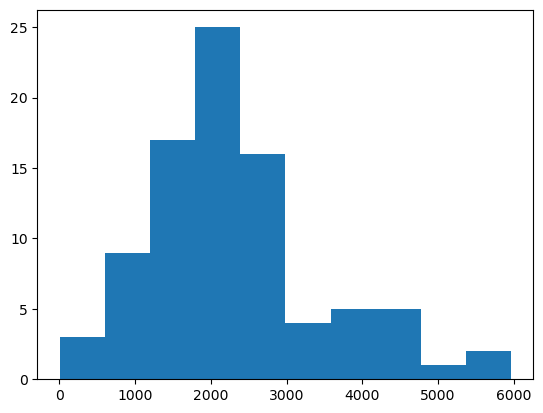

In [12]:
# make histogram of combined_data[combined_data["News_kind"] == "Local"]
import matplotlib.pyplot as plt

plt.hist(combined_data[combined_data["News_kind"] == "Local"]["Article Count"])

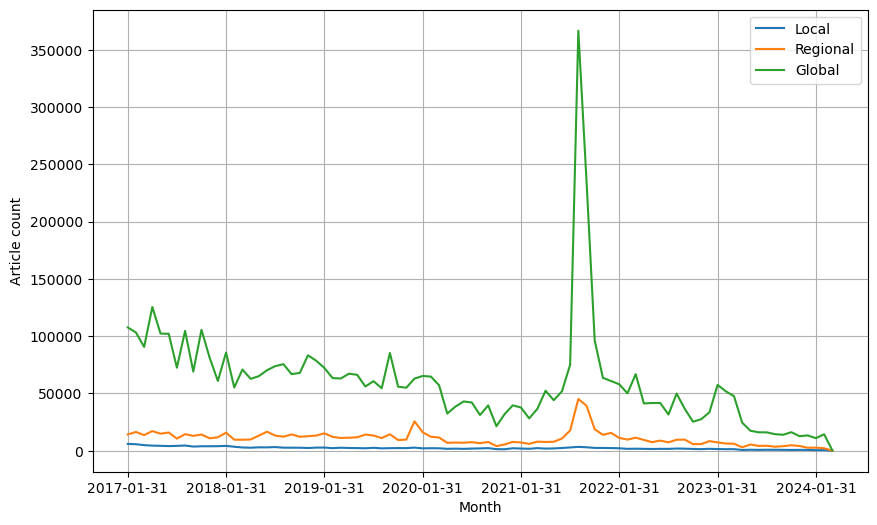

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for kind in ["Local", "Regional", "International"]:
    data = combined_data[combined_data["News_kind"] == kind]
    plt.plot(data["Month"], data["Article Count"])
plt.xlabel('Month')
plt.ylabel('Article count')
# plt.title('Article count over time')
plt.xticks(data["Month"][::12])  # Ensure all months are shown on x-axis
plt.legend(["Local", "Regional", "Global"])
plt.grid(True)
plt.show()

Now we to compute the change for all the themes, and the amount of fatalitites in t+1 till t+6, as well as the log change. 

In [113]:
newskinds = ["Local", "Regional", "International"]

df_list = {}

for newskind in newskinds:
    # make df
    df = combined_data[combined_data["News_kind"] == newskind].copy().reset_index()

    fatalities = df["fatalities"]

    # compute change for all theme columns
    themes_columns = df.columns.tolist()[3:-6]

    new_columns = []
    change_columns = []
    
    for column in themes_columns:
        # Make new column
        prev_month_column = df[column].shift(1)
        # Calculate the log change
        change_column =  np.log(df[column]+1) - np.log(prev_month_column+1)
        
        # Append column to new column list
        new_columns.append(change_column.rename(f"{column} change"))
        change_columns.append(f"{column} change")


    predictor_columns = []
    for i in range(6):
        df[f"fatalities t+{i+1}"] = df["fatalities"].shift(-i-1)
        # compute log change
        df[f"log change t+{i+1}"] = np.log(df["fatalities"] + 1) - np.log(df[f"fatalities t+{i+1}"])
        predictor_columns.append(f"fatalities t+{i+1}")
        predictor_columns.append(f"log change t+{i+1}")

    # compute contemporaneous levels of violence, cumulated best, and months since thresholds
    columns_to_add = [
        ("fatalities t-1", df["fatalities"].shift(1)),
        ("fatalities t-2", df["fatalities"].shift(2)),
        ("fatalities t-3", df["fatalities"].shift(3)),
        ("cumulated_best_3", df["fatalities"].rolling(window=3).max()),
        ("cumulated_best_6", df["fatalities"].rolling(window=6).max()),
        ("cumulated_best_12", df["fatalities"].rolling(window=12).max()),
        ("m_since_best_50", pd.Series(np.where(df['fatalities'] > 50, 0, np.nan)).ffill().groupby((df['fatalities'] > 50).cumsum()).cumcount()),
        ("m_since_best_500", pd.Series(np.where(df['fatalities'] > 500, 0, np.nan)).ffill().groupby((df['fatalities'] > 500).cumsum()).cumcount()),
        ("m_since_best_2000", pd.Series(np.where(df['fatalities'] > 2000, 0, np.nan)).ffill().groupby((df['fatalities'] > 2000).cumsum()).cumcount())
    ]


    for col_name, col_data in columns_to_add:
        new_columns.append(col_data.rename(col_name))

    # add to new columns
    for column in new_columns:
        df = pd.concat([df] + [column], axis=1)

    predictor_columns.append("fatalities")
    predictor_columns.append("log change")
    history_columns = ["fatalities", "fatalities t-1", "fatalities t-2", "fatalities t-3",
                       "cumulated_best_3", "cumulated_best_6", "cumulated_best_12",
                       "m_since_best_50", "m_since_best_500", "m_since_best_2000"]

    # add dataframe to dictionary
    df_list[newskind] = df

Then add the lists of column names to the dictionary

In [134]:
global_data = df_list["International"]
"log change t+2" in global_data.columns

True

In [124]:
df_list["pred_columns"] = predictor_columns
df_list["hist_columns"] = history_columns
df_list["theme_columns"] = themes_columns
df_list["change_columns"] = change_columns

And then we save the df dictionary to a pickle file

In [125]:
with open('../../data/Test_training/local_regional_global.pkl', 'wb') as f:
    pickle.dump(df_list, f)